# Tarefa 02 - Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

---

In [1]:
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns

from sklearn.tree          import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree          import DecisionTreeClassifier
from sklearn.metrics       import accuracy_score
from sklearn.metrics       import ConfusionMatrixDisplay

In [2]:
filename_features = "../Dados/UCI HAR Dataset/features.txt"
filename_labels   = "../Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "../Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain   = "../Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain   = "../Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "../Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest  = "../Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest   = "../Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#").squeeze("columns")
labels   = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns")
X_train       = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train       = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns")
X_test       = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test       = pd.read_csv(filename_ytest, header=None, names=['cod_label'])


In [3]:
# Resumo estatístico da base de treinamento SEM a padronização das variáveis
X_train.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
1 tBodyAcc-mean()-X,7352.0,0.274488,0.070261,-1.000000,0.262975,0.277193,0.288461,1.000000
2 tBodyAcc-mean()-Y,7352.0,-0.017695,0.040811,-1.000000,-0.024863,-0.017219,-0.010783,1.000000
3 tBodyAcc-mean()-Z,7352.0,-0.109141,0.056635,-1.000000,-0.120993,-0.108676,-0.097794,1.000000
4 tBodyAcc-std()-X,7352.0,-0.605438,0.448734,-1.000000,-0.992754,-0.946196,-0.242813,1.000000
5 tBodyAcc-std()-Y,7352.0,-0.510938,0.502645,-0.999873,-0.978129,-0.851897,-0.034231,0.916238
...,...,...,...,...,...,...,...,...
"557 angle(tBodyGyroMean,gravityMean)",7352.0,0.008726,0.608303,-1.000000,-0.482273,0.008735,0.506187,0.998702
"558 angle(tBodyGyroJerkMean,gravityMean)",7352.0,-0.005981,0.477975,-1.000000,-0.376341,-0.000368,0.359368,0.996078
"559 angle(X,gravityMean)",7352.0,-0.489547,0.511807,-1.000000,-0.812065,-0.709417,-0.509079,1.000000
"560 angle(Y,gravityMean)",7352.0,0.058593,0.297480,-1.000000,-0.017885,0.182071,0.248353,0.478157


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

Quando as variáveis estão em métricas muito diferentes, isso pode interferir na análise de componentes principais. Como a variância é uma fonte de informação importante para nós, é importante considerar que variáveis com escalas muito diferentes podem dominar a análise. Por exemplo, uma variável monetária, como salário, geralmente terá uma variabilidade muito maior do que o número de filhos ou o tempo de emprego. Nesses casos, é comum utilizar a padronização das variáveis.

Realizamos duas análises de componentes principais para a base de dados do HAR - uma com padronização e outra sem - e comparamos os resultados:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Determinação do número de componentes necessários para explicar 90% da variância em cada caso.

In [4]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad  = pd.DataFrame(X_test).apply(padroniza, axis=0)


CPU times: total: 312 ms
Wall time: 387 ms


In [5]:
# Resumo estatístico da base de treinamento COM a padronização das variáveis
X_train_pad.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
1 tBodyAcc-mean()-X,7352.0,-3.160330e-16,1.0,-18.139254,-0.163858,0.038502,0.198872,10.325905
2 tBodyAcc-mean()-Y,7352.0,4.639017e-17,1.0,-24.069884,-0.175631,0.011671,0.169379,24.937083
3 tBodyAcc-mean()-Z,7352.0,8.794803e-17,1.0,-15.729779,-0.209266,0.008206,0.200360,19.583956
4 tBodyAcc-std()-X,7352.0,-1.507680e-16,1.0,-0.879276,-0.863128,-0.759376,0.808108,3.577703
5 tBodyAcc-std()-Y,7352.0,7.731695e-18,1.0,-0.972726,-0.929466,-0.678330,0.948397,2.839333
...,...,...,...,...,...,...,...,...
"557 angle(tBodyGyroMean,gravityMean)",7352.0,-1.618824e-17,1.0,-1.658262,-0.807162,0.000015,0.817786,1.627440
"558 angle(tBodyGyroJerkMean,gravityMean)",7352.0,3.672555e-17,1.0,-2.079646,-0.774853,0.011743,0.764368,2.096467
"559 angle(X,gravityMean)",7352.0,8.891449e-17,1.0,-0.997354,-0.630155,-0.429596,-0.038163,2.910370
"560 angle(Y,gravityMean)",7352.0,-1.159754e-17,1.0,-3.558535,-0.257085,0.415080,0.637890,1.410395


---

#### Análise de componentes principais (PCA) para a base de treinamento SEM padronização

In [6]:
%%time

pca = PCA()
# Cria uma instância do objeto PCA, que será usado para realizar a análise de componentes principais

princomp = pca.fit(X_train)
# Ajusta o PCA aos dados de treinamento para extrair as componentes principais

componentes = princomp.transform(X_train)
# Transforma os dados de treinamento nas componentes principais

n_componentes = X_train.shape[1]
# Obtém o número de colunas dos dados de treinamento

nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]
# Cria uma lista de nomes para as componentes principais (CP1, CP2, CP3, ...)

pd.DataFrame(data=componentes, columns=nomes_pca)
# Visualiza o DataFrame com os dados transformados (componentes) e atribui os nomes_pca como nomes de colunas


CPU times: total: 1.02 s
Wall time: 551 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,-2.507387e-16,3.255294e-17,-1.522488e-16,-2.217417e-16,3.649249e-17,-2.603192e-15,1.826308e-16,-4.042930e-17,4.768898e-17,2.309673e-16
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-9.414486e-17,5.110279e-17,6.345822e-17,-5.915992e-17,8.181054e-17,1.060092e-15,-1.774786e-17,-3.620894e-17,6.504878e-17,-1.798446e-17
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-1.312771e-16,1.241059e-16,-1.656045e-17,-1.326179e-16,1.700097e-16,-2.287696e-15,3.345865e-19,-2.357091e-17,-1.809098e-17,1.532553e-17
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,-8.749241e-17,1.003091e-16,-9.353785e-17,-8.782648e-17,9.227011e-17,5.056512e-16,5.860494e-17,1.853749e-17,-2.769498e-17,1.336309e-17
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,-9.832375e-17,-9.125433e-18,-2.587428e-17,-2.667388e-17,9.455448e-17,3.857829e-16,5.261196e-17,-1.678569e-16,-1.119070e-16,6.686770e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285,...,3.363354e-17,7.708378e-17,-7.062225e-17,7.336060e-17,-1.016863e-16,-9.626875e-16,-2.479096e-16,1.083311e-16,6.548817e-18,4.354481e-17
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650,...,1.222003e-16,-9.544249e-17,1.339730e-16,8.927167e-17,3.957933e-17,-2.841440e-15,-1.460375e-17,7.258173e-17,-2.177846e-16,-1.902642e-16
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849,...,1.800066e-17,-4.149272e-17,4.695479e-17,1.405443e-16,-1.105143e-17,2.786737e-16,-1.567237e-16,-9.119132e-17,-6.630552e-18,-2.686676e-16
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171,...,1.214232e-16,-1.377039e-16,-1.139294e-16,1.910490e-16,-1.613507e-16,-4.633316e-15,-1.247958e-16,-1.357412e-16,-6.897128e-17,-1.410179e-16


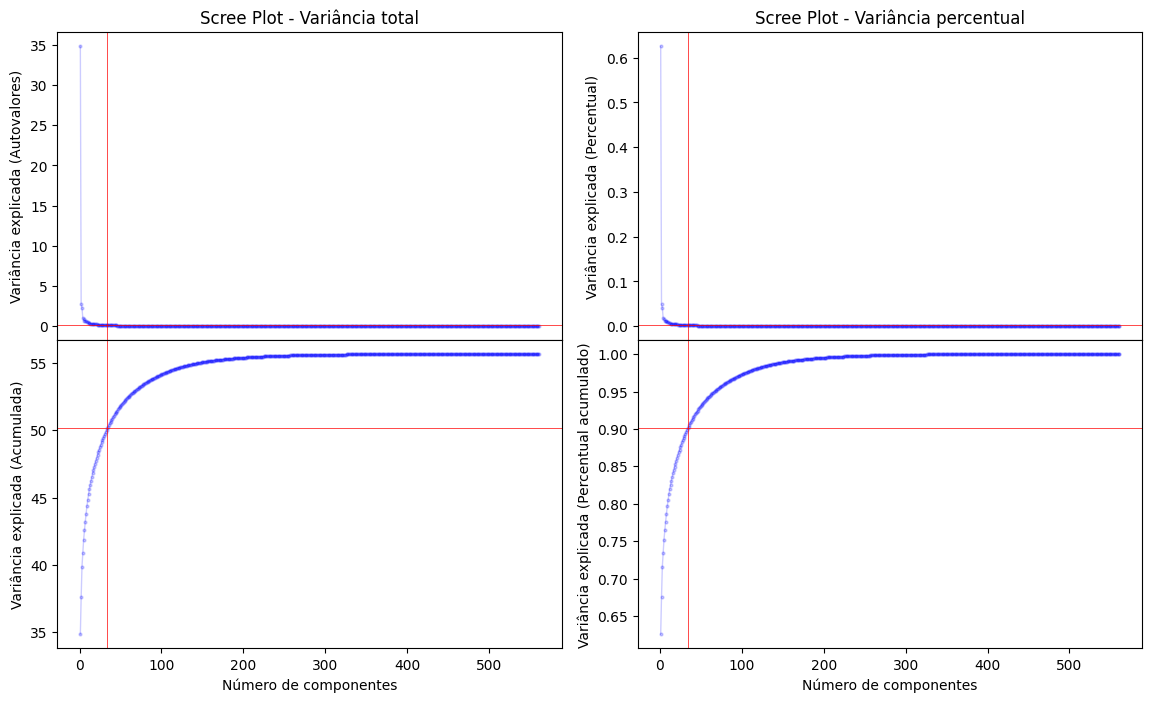

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 34 componentes.


In [7]:
# Critério: Variância explicada

# Cria uma figura com 2 linhas e 2 colunas de subplots e ajusta o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
# Calcula o número de componentes necessário para atingir a variância explicada desejada

# Gráfico da variância nominal por quantidade de componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0, 0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=princomp.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')


In [8]:
variancia               = princomp.explained_variance_[ncomp_criterio - 1]
variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_criterio - 1]
pct_variancia           = princomp.explained_variance_ratio_[ncomp_criterio - 1]
pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio - 1]

print(f'Número de componentes:...................... {ncomp_criterio}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')


Número de componentes:...................... 34
Variância da última CP:..................... 0.13
Variância acumulada da última CP:........... 50.15
Variância percentual da última CP:.......... 0.24%
Variância percentual acumulada da última CP: 90.09%


In [9]:
pca_raw = pd.DataFrame(data={'variancia': princomp.explained_variance_[:ncomp_criterio], 
                             'variancia_acumulada': princomp.explained_variance_.cumsum()[:ncomp_criterio], 
                             'pct_variancia': princomp.explained_variance_ratio_[:ncomp_criterio], 
                             'pct_variancia_acumulada': princomp.explained_variance_ratio_.cumsum()[:ncomp_criterio]}, 
                       index=list(range(1, ncomp_criterio+1)))
pca_raw.index.name = 'CP'
pca_raw


,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,34.823630,34.823630,0.625544,0.625544
2,2.735046,37.558677,0.049130,0.674675
3,2.294393,39.853070,0.041215,0.715889
4,1.043775,40.896845,0.018750,0.734639
5,0.943517,41.840362,0.016949,0.751587
6,0.708152,42.548514,0.012721,0.764308
7,0.655053,43.203567,0.011767,0.776075
8,0.595090,43.798657,0.010690,0.786765
9,0.539647,44.338304,0.009694,0.796459


---

#### Análise de componentes principais (PCA) para a base de treinamento COM padronização

In [10]:
%%time

pca_pad = PCA()
# Cria uma instância do objeto PCA, que será usado para realizar a análise de componentes principais

princomp_pad = pca_pad.fit(X_train_pad)
# Ajusta o PCA aos dados de treinamento para extrair as componentes principais

componentes_pad = princomp_pad.transform(X_train_pad)
# Transforma os dados de treinamento nas componentes principais

n_componentes_pad = X_train_pad.shape[1]
# Obtém o número de colunas dos dados de treinamento

nomes_pca_pad = ['CP' + str(x+1) for x in list(range(n_componentes_pad))]
# Cria uma lista de nomes para as componentes principais (CP1, CP2, CP3, ...)

pd.DataFrame(data=componentes_pad, columns=nomes_pca_pad)
# Visualiza o DataFrame com os dados transformados (componentes) e atribui os nomes_pca como nomes de colunas


CPU times: total: 1.09 s
Wall time: 544 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,2.313779e-17,2.622688e-16,2.411694e-16,3.860948e-16,-5.750640e-17,-4.188258e-16,-6.724645e-17,-3.807996e-17,9.875299e-15,-2.075705e-16
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,9.116656e-18,3.619778e-16,-4.842084e-17,-8.623612e-18,-2.795717e-16,-3.063969e-16,2.796265e-17,-2.946831e-16,-1.472089e-15,1.781203e-16
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,-5.551776e-16,1.680594e-16,-2.118475e-17,-6.177556e-18,-3.026422e-16,-1.823342e-16,-4.350475e-17,-8.558949e-17,-7.697869e-15,-6.173625e-16
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,-2.707436e-16,-1.986989e-17,1.342549e-16,2.378687e-17,4.885221e-18,-3.860418e-16,-9.428756e-17,-1.250611e-16,7.222283e-16,-6.707809e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-1.650412e-16,3.172731e-16,-1.673759e-16,-1.661967e-16,-1.718882e-16,-5.462379e-16,-2.624475e-16,-2.669555e-16,-6.613019e-15,-3.074802e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,15.464009,-12.535453,1.999041,3.457489,-1.523091,-2.698944,-3.561009,2.418529,0.383154,1.308633,...,4.052851e-17,-1.383073e-16,1.479759e-17,-5.475411e-17,3.022439e-16,2.627134e-16,-8.514969e-19,-1.251666e-16,-1.187797e-14,7.875820e-16
7348,14.221755,-10.252804,2.377499,2.802476,-1.325223,-4.345821,-2.193817,0.032138,-0.528893,0.702462,...,2.246974e-17,2.365735e-17,3.702395e-16,-5.935274e-17,1.413869e-16,-5.519431e-16,-3.405618e-16,2.762347e-17,-5.998694e-15,9.438534e-16
7349,14.332461,-12.259878,4.025672,3.849518,-2.860295,-3.623803,-3.929374,-0.873103,-0.746280,-1.575419,...,5.898976e-17,-6.443647e-16,1.885905e-16,-3.246150e-16,2.604469e-16,5.929732e-17,1.586768e-16,2.663583e-16,1.511081e-15,4.670141e-16
7350,12.875143,-14.070299,2.915863,5.013085,-3.937957,-2.137461,-5.390033,0.321283,-0.916237,-1.646259,...,6.330152e-16,-2.978067e-16,-4.005346e-17,-7.050101e-17,3.094845e-16,1.482487e-16,2.424362e-16,-1.051898e-16,8.294116e-15,4.626246e-16


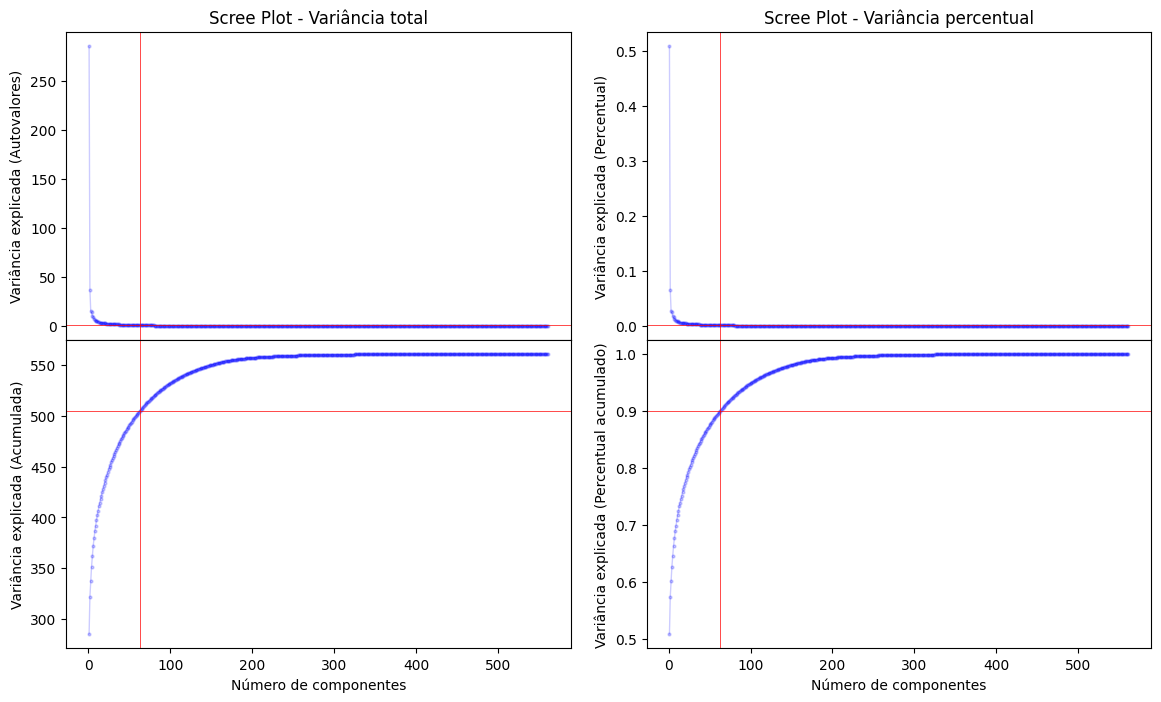

Para explicar 90% da variância com a padronização das variáveis, são necessárias 63 componentes.
Para o critério de autovalor > 1, são necessárias 61 componentes.


In [11]:
# Critério: Variância explicada

# Cria uma figura com 2 linhas e 2 colunas de subplots e ajusta o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio_pad = (princomp_pad.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
# Calcula o número de componentes necessário para atingir a variância explicada desejada

# Gráfico da variância nominal por quantidade de componentes
num_componentes_pad = np.arange(princomp_pad.n_components_) + 1
ax[0, 0].plot(num_componentes_pad, princomp_pad.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes_pad, princomp_pad.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=princomp_pad.explained_variance_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp_pad.explained_variance_ratio_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância com a padronização das variáveis, são necessárias {ncomp_criterio_pad} componentes.')

criterio_autovalor = (princomp_pad.explained_variance_ratio_ > 1 / princomp_pad.n_components_).sum()
print(f'Para o critério de autovalor > 1, são necessárias {criterio_autovalor} componentes.')


In [12]:
variancia               = princomp_pad.explained_variance_[ncomp_criterio_pad - 1]
variancia_acumulada     = princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad - 1]
pct_variancia           = princomp_pad.explained_variance_ratio_[ncomp_criterio_pad - 1]
pct_variancia_acumulada = princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad - 1]

print(f'Número de componentes:...................... {ncomp_criterio_pad}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')


Número de componentes:...................... 63
Variância da última CP:..................... 0.99
Variância acumulada da última CP:........... 505.20
Variância percentual da última CP:.......... 0.18%
Variância percentual acumulada da última CP: 90.05%


In [13]:
pca_pad = pd.DataFrame(data={'variancia': princomp_pad.explained_variance_[:ncomp_criterio_pad], 
                             'variancia_acumulada': princomp_pad.explained_variance_.cumsum()[:ncomp_criterio_pad], 
                             'pct_variancia': princomp_pad.explained_variance_ratio_[:ncomp_criterio_pad], 
                             'pct_variancia_acumulada': princomp_pad.explained_variance_ratio_.cumsum()[:ncomp_criterio_pad]}, 
                       index=list(range(1, ncomp_criterio_pad+1)))
pca_pad.index.name = 'CP'
pca_pad


,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,284.882377,284.882377,0.507812,0.507812
2,36.917616,321.799993,0.065807,0.573619
3,15.744110,337.544103,0.028064,0.601683
4,14.047175,351.591278,0.025040,0.626722
5,10.593279,362.184557,0.018883,0.645605
...,...,...,...,...
59,1.055044,501.154215,0.001881,0.893323
60,1.044672,502.198886,0.001862,0.895185
61,1.018027,503.216914,0.001815,0.897000


---

## Árvore com PCA

Faça duas árvores de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

#### Árvore de decisão com base em dados não padronizados

In [14]:
%%time

# Aplica o PCA com 10 componentes aos dados de treinamento SEM padronização
prcomp = PCA(n_components=10).fit(X_train)

# Transforma os dados de treinamento e teste utilizando as componentes principais encontradas pelo PCA
pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

# Imprime a forma dos dados de treinamento e teste após a transformação
print(f'Dimensões da base de treinamento: {pc_treino.shape}')
print(f'Dimensões da base de teste: {pc_teste.shape}\n')

# Inicializa um classificador de árvore de decisão com ccp_alpha=0.001 e treina-o com os dados de treinamento transformados
clf = DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(pc_treino, y_train)

# Calcula e imprime a acurácia do classificador nos dados de treinamento e teste
print(f'Acurácia na base de treinamento: {clf.score(pc_treino, y_train)}')
print(f'Acurácia na base de teste: {clf.score(pc_teste, y_test)}\n')


Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8934983677910773
Acurácia na base de teste: 0.823549372242959

CPU times: total: 78.1 ms
Wall time: 220 ms


#### Árvore de decisão com base em dados padronizados

In [15]:
%%time

# Aplica o PCA com 10 componentes aos dados de treinamento COM padronização
prcomp_pad = PCA(n_components=10).fit(X_train_pad)

# Transforma os dados de treinamento e teste utilizando as componentes principais encontradas pelo PCA
pc_treino_pad = prcomp_pad.transform(X_train_pad)
pc_teste_pad  = prcomp_pad.transform(X_test_pad)

# Imprime a forma dos dados de treinamento e teste após a transformação
print(f'Dimensões da base de treinamento: {pc_treino_pad.shape}')
print(f'Dimensões da base de teste: {pc_teste_pad.shape}\n')

# Inicializa um classificador de árvore de decisão com ccp_alpha=0.001 e treina-o com os dados de treinamento transformados
clf_pad = DecisionTreeClassifier(ccp_alpha=0.001)
clf_pad.fit(pc_treino_pad, y_train)

# Calcula e imprime a acurácia do classificador nos dados de treinamento e teste
print(f'Acurácia na base de treinamento: {clf_pad.score(pc_treino_pad, y_train)}')
print(f'Acurácia na base de teste: {clf_pad.score(pc_teste_pad, y_test)}\n')


Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8586779107725789
Acurácia na base de teste: 0.7736681370885646

CPU times: total: 93.8 ms
Wall time: 210 ms


#### Comparação de Classificadores por meio de Matrizes de Confusão e Acurácia

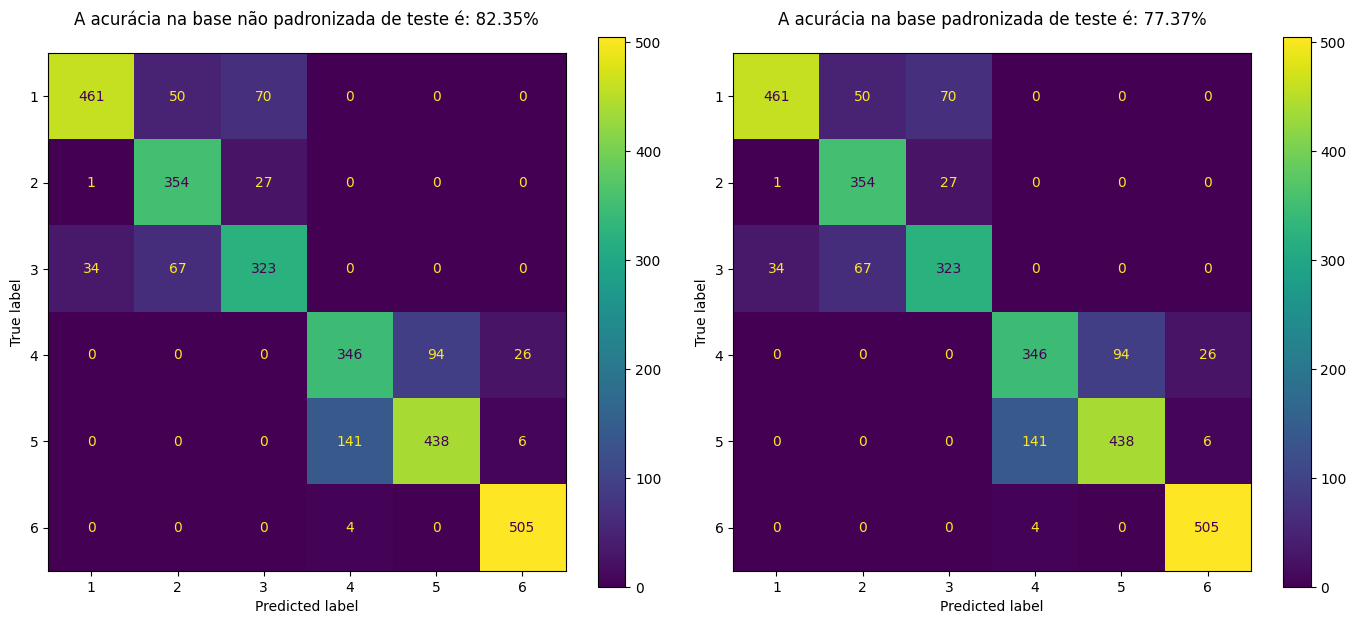

In [16]:
# Realiza a previsão dos dados
y_pred = clf.predict(pc_teste)
y_pred_pad = clf_pad.predict(pc_teste_pad)

# Cria uma figura com 1 linha e 2 colunas e define o tamanho da figura
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Configura o título do primeiro subgráfico com a acurácia na base não padronizada de teste
ax[0].set_title(f'A acurácia na base não padronizada de teste é: {accuracy_score(y_pred, y_test) * 100:.2f}%\n')

# Plota a matriz de confusão do primeiro subgráfico
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[0])

# Configura o título do segundo subgráfico com a acurácia na base padronizada de teste
ax[1].set_title(f'A acurácia na base padronizada de teste é: {accuracy_score(y_pred_pad, y_test) * 100:.2f}%\n')

# Plota a matriz de confusão do segundo subgráfico
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[1])

# Ajusta o layout dos subgráficos para evitar sobreposições
plt.tight_layout()

# Exibe o gráfico
plt.show()


---